# Summarial Data Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

#plt.rcParams['text.usetex'] = True


To download the dataset, use or adapt the following:

In [2]:
import subprocess

current_directory = os.getcwd()

# Define the scp command
scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-joineddat-first100.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

scp_command = f"scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-joined-dataset.csv {current_directory}/data_utils/."
subprocess.run(scp_command, shell=True)

scp: /home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-joineddat-first100.csv: No such file or directory
scp: /home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-joined-dataset.csv: No such file or directory


CompletedProcess(args='scp glasswing:/home/ecol/Documents/RaCA-SOC-a-spectrum-analysis/RaCA-SOC-a/RaCA-joined-dataset.csv /Users/ecol/Documents/RaCA-Analysis/data_utils/.', returncode=1)

Note that the joined dataset is around 6.5 GB.

TODO: Host dataset somewhere accessible publicly.

## Reading the joined RaCA dataset into memory

You can use the first 100 entries if you prefer to keep your workflow memory-light for test purposes:

In [2]:
current_directory = os.getcwd()
joined = pd.read_csv(f"{current_directory}/data_utils/RaCA-fulldat-first100.csv")

Otherwise, import the joined dataset as follows:

In [2]:
# load pandas dataframe from h5
current_directory = os.getcwd()
joined = pd.read_hdf(f"{current_directory}/data_utils/ICLRDataset_RaCAFullDataset.h5", key="df")

## Understanding SOC estimates

First, before implementing selection cuts, let's understand how many datapoints we have and what they signify.

In [207]:
print("Total nonzero TC entries:",((joined['c_tot_ncs'] != 0).astype(int)).sum())
print("Total nonnegative TC entries:",((joined['c_tot_ncs'] >= 0).astype(int)).sum())
print("Total negative TC entries:",((joined['c_tot_ncs'] <= 0).astype(int)).sum())
print()
print("Total nonzero SOC entries:",((joined['soc'] != 0).astype(int)).sum())
print("Total nonnegative SOC entries:",((joined['soc'] >= 0).astype(int)).sum())
print("Total negative SOC entries:",((joined['soc'] < 0).astype(int)).sum())
print()
print("TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.")
print("Total nonzero carbonate entries:",((joined['caco3'] != 0).astype(int)).sum())
print("Total nonnegative carbonate entries:",((joined['caco3'] >= 0).astype(int)).sum())
print("Total negative carbonate entries:",((joined['caco3'] < 0).astype(int)).sum())
print()
print("Total nonzero 351nm reflectance entries:",((joined['351'] != 0).astype(int)).sum())
print("Total nonnegative 351nm reflectance entries:",((joined['351'] >= 0).astype(int)).sum())
print("Total negative 351nm reflectance entries:",((joined['351'] < 0).astype(int)).sum())

Total nonzero TC entries: 352850
Total nonnegative TC entries: 80878
Total negative TC entries: 0

Total nonzero SOC entries: 351930
Total nonnegative SOC entries: 352850
Total negative SOC entries: 0

TODO: 'caco3' entry should really just be CO3 content, not strictly calcite. Confirm with soilDB admins.
Total nonzero carbonate entries: 352850
Total nonnegative carbonate entries: 42406
Total negative carbonate entries: 1458

Total nonzero 351nm reflectance entries: 352850
Total nonnegative 351nm reflectance entries: 352374
Total negative 351nm reflectance entries: 476


The takeaway from the above is that:
- We have 80,878 analyses of total carbon
- We have only 43,406 analyses of calcite content
- Thus, the maximum number of direct SOC estimates we can make from TC - CO3 is 43,406
- We have more analyses of SOC than total carbon
- Thus, SOC estimates are not coming from laboratory estimates
- SoilDB documentation indicates these SOC values are modeled from the spectral data

The immediate next questions are:
- How many of the SOC values are not modeled?
- When a direct SOC estimate is available, is that reflected as TC - CO3 in some way?

Here are the fields scraped from soilDB in the Pandas dataframe:

- 350 to 2500: Reflectance data
- rcapid: RaCA pedon ID
- sample_top: Depth of top of sample (cm)
- sample_bottom: Depth of bottom of sample (cm)
- hzname_x: Horizon classification (x vs y?)
- texture_x: USDA texture classification
- frag_vol: % by volume of the sample that is >2mm in size (and does not enter scan) (?)
- bd: Bulk density (units?)
- bd_sd: Standard deviation of bulk density (units?)
- bd_source: Either "modeled" or "measured"
- bd_method: How bulk density was determined
- soc: Soil organic carbon mass fraction
- soc_sd: Standard deviation of SOC content (absolute/relative?)
- soc_measured: Either "modeled" or "measured"
- soc_scan: Always NaN
- soc_lab: SOC content determined in the lab (?)
- x: Approximate longitude of sample
- y: Approximate latitude of sample
- pedon_id: (rcapid) + "-" + (sample number within pedon)
- samp: (rcapid) - (last digit of rcapid) + "-" + (sample number within pedon)
- sample.id: (?)
- TOP: Depth of top of pedon (cm) (?)
- BOT: Depth of bottom of pedon (cm) (?)
- hzn_desgn: Horizon designation (similar to classification?)
- rcasiteid: (rcapid) - (last digit of rcapid) (?)
- pedon_no: Pedon number within sample campaign
- MO: (?)
- MOGr: (?) something related to land use?
- hor_top: Depth of top of horizon
- hor_bot: Depth of bottom of horizon
- fragvolc: The volume percentage of the horizon occupied by the 2 mm or larger fraction (20 mm or larger for wood fragments), on a whole soil base. Does not enter scan.
- Bulkdensity: Same as bd?
- SOC_pred1: SOC mass abundance prediction
- BD1: Something related to bulk density?
- upedonid: Roughly the same as pedon_id?
- upedon: Roughly the same as rcapid?
- LU: Land use classification
- MOGrLU: Something related to land use (?)
- hzname_y: Horizon classification (x vs y?)
- model_desg1: (?)
- texture_y: USDA texture classification (x vs y?)
- BDmeasured: Either "modeled" or "measured"
- BDmethod: How bulk density was determined
- Lab.Sample.No: ID for laboratory purposes (?)
- lab_proj_name: Separate ID for laboratory purposes (?)
- submit_proj_name: Always "RaCA MO(N1) Analysis/Archived Part N2"
- user_site_id: Possible same as rcapid (?)
- smp_id: (?)
- lay_field_label1: (?) str
- lay_field_label2: (?) str
- lay_field_label3: (?) str
- lay_depth_to_top: (?) (cm?)
- lay_depth_to_bottom: (?) (cm?)
- horizon_designation: Horizon classification (x vs y vs this? all different)
- natural_key: (?)
- lay_id: (?)
- adod: Ratio of (Air dried sample mass)/(Oven dried sample mass)
- c_tot_ncs: Total carbon content
- n_tot_ncs: Total nitrogen content
- s_tot_ncs: Total sulfur content
- caco3: Total carbonate content
- efferv_1nhcl: Results of an effervescence test
- M: (?)
- Model_desg: (?) same as model_desg1?
- Texture: USDA texture classification
- Measure_BD: Measured bulk density (units?)
- Model_BD: Modeled bulk density (units?)

## Implementing selection cuts

If ADOD is the ratio of air-dried mass to oven-dried mass, then ADOD > 1 and the mass percentage of water in the air-dried sample is 1 - 1/ADOD.

If ADOD is too high, then there is a chance that the sample was not joinedy or properly air-dried before the VNIR scan data was collected. The possibility of this happening is reflected in the RaCA documentation: sample collection teams were originally permitted to collect both air-dried and field-moist samples. It is possible that this is noted somewhere in soilDB (TODO: check with admins), but it is not documented how to distinguish between spectra for identical samples where one is air-dried and one is field-moist. This means that spectral features associated to water in liquid phase could contaminate the data. As such, we should at minimum discard samples where ADOD is above some threshold. Here, we analyze this selection cut in detail. 

Total nonnegative SOC:  66291
Further require spectrum to exist: 66291
Further require ADOD to exist: 20929
Further require <20% water by mass: 20923


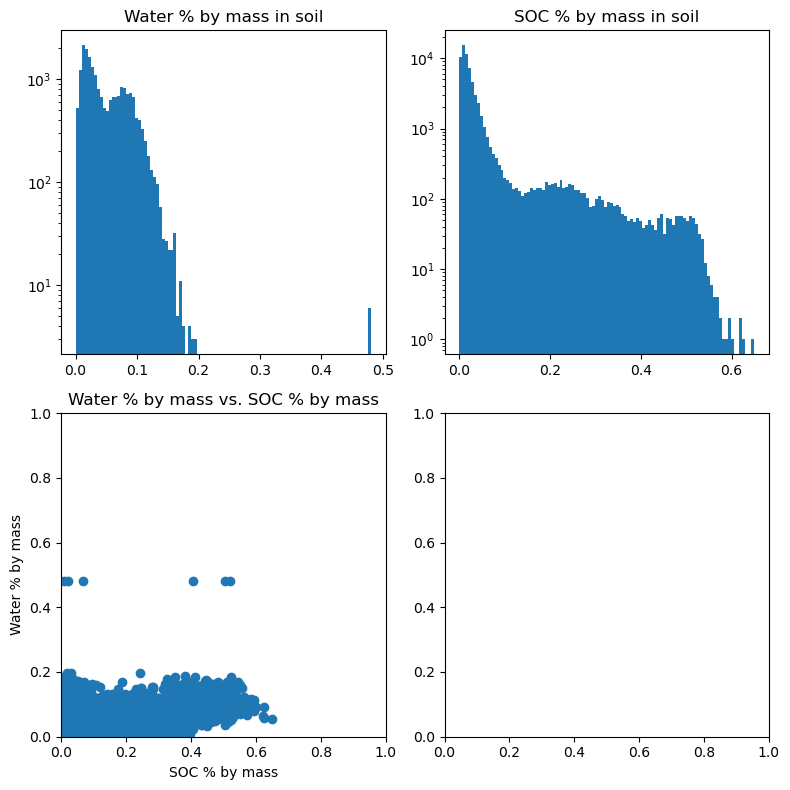

In [18]:
print("Total nonnegative SOC: ",((joined['soc'] > 0).astype(int)).sum())
print("Further require spectrum to exist:",((joined['soc'] > 0).astype(int) * (joined['500'] > 0).astype(int)).sum())
print("Further require ADOD to exist:",((joined['soc'] > 0).astype(int) * (joined['500'] > 0).astype(int) * (joined['adod'] > 0).astype(int)).sum())
print("Further require <20% water by mass:",((joined['soc'] > 0).astype(int) * (joined['500'] > 0).astype(int) * (joined['adod'] > 0).astype(int) * ((1-1/joined['adod']) < 0.2).astype(int)).sum())


fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the first subplot
axs[0, 0].hist(1 - 1/joined['adod'], bins=100)
axs[0, 0].set_title("Water % by mass in soil")
axs[0, 0].set_yscale('log')

# Plot the second subplot
axs[0, 1].hist(joined['soc']/100, bins=100)
axs[0, 1].set_title("SOC % by mass in soil")
axs[0, 1].set_yscale('log')

# Plot the third subplot
axs[1, 0].scatter(joined['soc']/100,(1-1/joined['adod']))
axs[1, 0].set_title("Water % by mass vs. SOC % by mass")
axs[1, 0].set_xlabel("SOC % by mass")
axs[1, 0].set_ylabel("Water % by mass")
axs[1, 0].set_xlim([0,1.])
axs[1, 0].set_ylim([0,1.])

# Plot the fourth subplot
# axs[1, 1].hist(1 - 1/joined['adod'], bins=100)
# axs[1, 1].set_title("Water % by mass in soil")
# axs[1, 1].set_yscale('log')

# Adjust the spacing between subplots
plt.tight_layout()


Next we want to check whether there are duplicates of (spectrum, soc) pairs.

In [11]:
# Select the columns representing the spectrum and 'soc'
spectrum_cols = [str(i) for i in range(350, 2501)]
cols_to_check = spectrum_cols + ['soc']

# Remove duplicates based on the selected columns
joined = joined.drop_duplicates(subset=cols_to_check)

# Print the updated dataframe
#print(joined)


In [13]:
len(joined)

66468

## Splitting train/val by site 

First, we want to understand some summarial statistics regarding the sizes of sampling campaigns.

- Is site unique by location (x,y)?
- Is location (x,y) unique by site?
- What is the minimum distance between sites?
- What is the distribution of (k=1)NN distances between sites?
- What is the average site size?
- What is the per-site SOC variability?

Is location unique for a given site?

In [16]:
unique_rcasiteid = joined['rcasiteid'].unique()

for rcasiteid in unique_rcasiteid:
    subset = joined[joined['rcasiteid'] == rcasiteid]
    unique_x = subset['x'].unique()
    unique_y = subset['y'].unique()
    
    if len(unique_x) > 1 or len(unique_y) > 1:
        print(f"rcasiteid {rcasiteid} has non-unique 'x' or 'y' values.")


The answer is yes.

Is site unique for a given location?

In [17]:
# Group the dataframe by 'x' and 'y' and count the number of unique 'rcasiteid' values
site_counts = joined.groupby(['x', 'y'])['rcasiteid'].nunique()

# Find the combinations where 'rcasiteid' is not unique
non_unique_sites = site_counts[site_counts > 1]

# Print the non-unique combinations
if len(non_unique_sites) > 0:
    print("Non-unique 'rcasiteid' combinations:")
    for index, count in non_unique_sites.items():
        x, y = index
        print(f"x: {x}, y: {y}, count: {count}")
else:
    print("All 'rcasiteid' combinations are unique.")


Non-unique 'rcasiteid' combinations:
x: -124.03, y: 46.4, count: 2
x: -123.79, y: 46.37, count: 2
x: -123.0, y: 44.26, count: 2
x: -122.59, y: 48.83, count: 2
x: -122.44, y: 48.0, count: 2
x: -122.09, y: 47.24, count: 3
x: -122.08, y: 47.27, count: 2
x: -121.62, y: 37.59, count: 2
x: -120.31, y: 35.53, count: 2
x: -120.31, y: 39.49, count: 2
x: -120.17, y: 39.59, count: 2
x: -119.85, y: 39.36, count: 2
x: -119.71, y: 38.9, count: 2
x: -118.98, y: 38.62, count: 2
x: -114.42, y: 36.53, count: 2
x: -114.4, y: 38.32, count: 2
x: -114.29, y: 35.46, count: 2
x: -114.27, y: 38.29, count: 2
x: -114.1, y: 35.41, count: 2
x: -100.22, y: 47.89, count: 2
x: -99.84, y: 48.41, count: 2
x: -98.26, y: 46.56, count: 2
x: -95.48, y: 30.25, count: 2
x: -93.71, y: 35.65, count: 2
x: -92.25, y: 31.06, count: 2
x: -91.67, y: 33.95, count: 2
x: -90.06, y: 33.71, count: 2
x: -89.92, y: 35.69, count: 2
x: -87.75, y: 43.62, count: 2
x: -87.24, y: 44.99, count: 2
x: -85.85, y: 33.51, count: 3
x: -73.79, y: 42.57

Now we can write a basic script to split the dataset by joined sites:

In [ ]:
# Get the unique values of rcapid
unique_rcapid = joined['rcasiteid'].unique()

# Shuffle the unique values randomly
np.random.shuffle(unique_rcapid)

# Calculate the split index based on chunk lengths
total_length = 0
split_index = 0
for index, rcapid in enumerate(unique_rcapid):
    chunk_length = len(joined[joined['rcasiteid'] == rcapid])
    total_length += chunk_length
    if total_length >= len(joined) * 0.75:
        split_index = index + 1
        break

# Create the train dataframe
train = joined[joined['rcasiteid'].isin(unique_rcapid[:split_index])]

# Create the val dataframe
val = joined[joined['rcasiteid'].isin(unique_rcapid[split_index:])]

# Apply the buffer quantity constraint to the train dataframe
buffer_quantity = 500
train = train.groupby('rcasiteid').head(buffer_quantity)

# Print the sizes of train and val dataframes
print("Train size:", len(train))
print("Val size:", len(val))


# Experiments

In [213]:
import pandas as pd
import copy

# Load the CSV file into a pandas dataframe

dfETRMSEP = pd.read_csv("results/Encoder_Training_RMSEP_CV.csv")    # Encoder Training RMSEP
dfEVRMSEP = pd.read_csv("results/Encoder_Validation_RMSEP_CV.csv")  # Encoder Validation RMSEP
dfETR2    = pd.read_csv("results/Encoder_Training_R2_CV.csv")       # Encoder Training R2    
dfEVR2    = pd.read_csv("results/Encoder_Validation_R2_CV.csv")     # Encoder Validation R2
dfETBias  = pd.read_csv("results/Encoder_Training_Bias_CV.csv")     # Encoder Training Bias
dfEVBias  = pd.read_csv("results/Encoder_Validation_Bias_CV.csv")   # Encoder Validation Bias

dfDTRMSEP = pd.read_csv("results/Decoder_Training_RMSEP_CV.csv")    # Decoder Training RMSEP
dfDVRMSEP = pd.read_csv("results/Decoder_Validation_RMSEP_CV.csv")  # Decoder Validation RMSEP

uniqueNames = dfETRMSEP.keys()
uniqueNames = np.unique([x.split(' - ')[0] for x in uniqueNames])[1:]

In [217]:
dfEVR2['Step'].max()

20403

## Experiment 1: Comparing end-to-end approaches

In [299]:
result1 = []
result2 = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'nDTrue' not in name: continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('nDTrue', 'nDFalse')
    cpNm = cpNm.replace('dMFalse', 'dMTrue')

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]

    if EVR2EO < 0.0 : 
        print("\t- Encoder only R2 is negative", name)
    
    if EVR2ED < 0.0 :
        print("\t- Encoder-decoder R2 is negative", cpNm)

    result1.append(EVR2EO)
    result2.append(EVR2ED)

print(result1)
print(result2)

	- Encoder only R2 is negative glasswing_s_16_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_16_2_nDFalse_dRFalse_dMTrue_ffFalse
	- Encoder only R2 is negative glasswing_s_18_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_18_2_nDFalse_dRFalse_dMTrue_ffFalse
	- Encoder only R2 is negative glasswing_s_3_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_3_2_nDFalse_dRFalse_dMTrue_ffFalse
	- Encoder only R2 is negative glasswing_s_5_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_5_2_nDFalse_dRFalse_dMTrue_ffFalse
	- Encoder only R2 is negative glasswing_s_6_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_6_2_nDFalse_dRFalse_dMTrue_ffFalse
	- Encoder only R2 is negative glasswing_s_8_2_nDTrue_dRFalse_dMFalse_ffFalse
	- Encoder-decoder R2 is negative glasswing_s_8_2_nDFalse_dRFalse_dMTrue_ffFalse
[0.819612302, 0.765268941, 0.729169863, 0.

In [347]:
outlier_regions = [3,5,6,8,16,18]

In [348]:
rETBias = []
rETRMSEP = []
rETR2 = []
rEVBias = []
rEVRMSEP = []
rEVR2 = []

rDTRMSEP = []
rDVRMSEP = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'nDTrue' not in name: continue
    if int(name.split('_')[2]) in outlier_regions: 
        print("Skipping", name)
        continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('nDTrue', 'nDFalse')
    cpNm = cpNm.replace('dMFalse', 'dMTrue')

    ETBiasEO = dfETBias[name + ' - Encoder_Training_Bias'].dropna().values[-1]
    ETBiasED = dfETBias[cpNm + ' - Encoder_Training_Bias'].dropna().values[-1]

    ETRMSEPEO = dfETRMSEP[name + ' - Encoder_Training_RMSEP'].dropna().values[-1]
    ETRMSEPED = dfETRMSEP[cpNm + ' - Encoder_Training_RMSEP'].dropna().values[-1]

    ETR2EO = dfETR2[name + ' - Encoder_Training_R2'].dropna().values[-1]
    ETR2ED = dfETR2[cpNm + ' - Encoder_Training_R2'].dropna().values[-1]

    EVBiasEO = dfEVBias[name + ' - Encoder_Validation_Bias'].dropna().values[-1]
    EVBiasED = dfEVBias[cpNm + ' - Encoder_Validation_Bias'].dropna().values[-1]
    
    EVRMSEPEO = dfEVRMSEP[name + ' - Encoder_Validation_RMSEP'].dropna().values[-1]
    EVRMSEPED = dfEVRMSEP[cpNm + ' - Encoder_Validation_RMSEP'].dropna().values[-1]

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]


    DTRMSEPEO = dfDTRMSEP[name + ' - Decoder_Training_RMSEP'].dropna().values[-1]
    DTRMSEPED = dfDTRMSEP[cpNm + ' - Decoder_Training_RMSEP'].dropna().values[-1]

    DVRMSEPEO = dfDVRMSEP[name + ' - Decoder_Validation_RMSEP'].dropna().values[-1]
    DVRMSEPED = dfDVRMSEP[cpNm + ' - Decoder_Validation_RMSEP'].dropna().values[-1]

    rETBias.append(ETBiasED - ETBiasEO)
    rETRMSEP.append(ETRMSEPED - ETRMSEPEO)
    rETR2.append(ETR2ED - ETR2EO)
    rEVBias.append(EVBiasED - EVBiasEO)
    rEVRMSEP.append(EVRMSEPED - EVRMSEPEO)
    rEVR2.append(EVR2ED - EVR2EO)
    rDTRMSEP.append(DTRMSEPED)
    rDVRMSEP.append(DVRMSEPED)

print()
print("###############################:")
print("BIAS:")  
print("Average difference in encoder-only bias from encoder-decoder bias (Training) =",np.mean(np.array(rETBias))," +/- ",np.std(np.array(rETBias)))
print("Average difference in encoder-only bias from encoder-decoder bias (Validation) =",np.mean(np.array(rEVBias))," +/- ",np.std(np.array(rEVBias)))

print("###############################:")
print("RMSEP:")
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Training) =",np.mean(np.array(rETRMSEP))," +/- ",np.std(np.array(rETRMSEP)))
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Validation) =",np.mean(np.array(rEVRMSEP))," +/- ",np.std(np.array(rEVRMSEP)))

print("###############################:")
print("R2:")
print("Average difference in encoder-only bias from encoder-decoder R2 (Training) =",np.mean(np.array(rETR2))," +/- ",np.std(np.array(rETR2)))
print("Average difference in encoder-only bias from encoder-decoder R2 (Validation) =",np.mean(np.array(rEVR2))," +/- ",np.std(np.array(rEVR2)))

print("###############################:")
print("Decoder RMSEP:")
print("Average encoder-decoder decoder RMSEP (Training) =",np.mean(np.array(rDTRMSEP))," +/- ",np.std(np.array(rDTRMSEP)))
print("Average encoder-decoder decoder RMSEP (Validation) =",np.mean(np.array(rDVRMSEP))," +/- ",np.std(np.array(rDVRMSEP)))

Skipping glasswing_s_16_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_18_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_3_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_5_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_6_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_8_2_nDTrue_dRFalse_dMFalse_ffFalse

###############################:
BIAS:
Average difference in encoder-only bias from encoder-decoder bias (Training) = 0.00017970476363636366  +/-  0.0003999168384569001
Average difference in encoder-only bias from encoder-decoder bias (Validation) = -0.0004027552727272723  +/-  0.0018046863006019069
###############################:
RMSEP:
Average difference in encoder-only bias from encoder-decoder RMSEP (Training) = 7.87626363636364e-05  +/-  0.0004086372662076795
Average difference in encoder-only bias from encoder-decoder RMSEP (Validation) = 0.00040682218181818127  +/-  0.002989411424437618
###############################:
R2:
Average difference in 

Skipping glasswing_s_16_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_18_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_3_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_5_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_6_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_8_2_nDTrue_dRFalse_dMFalse_ffFalse



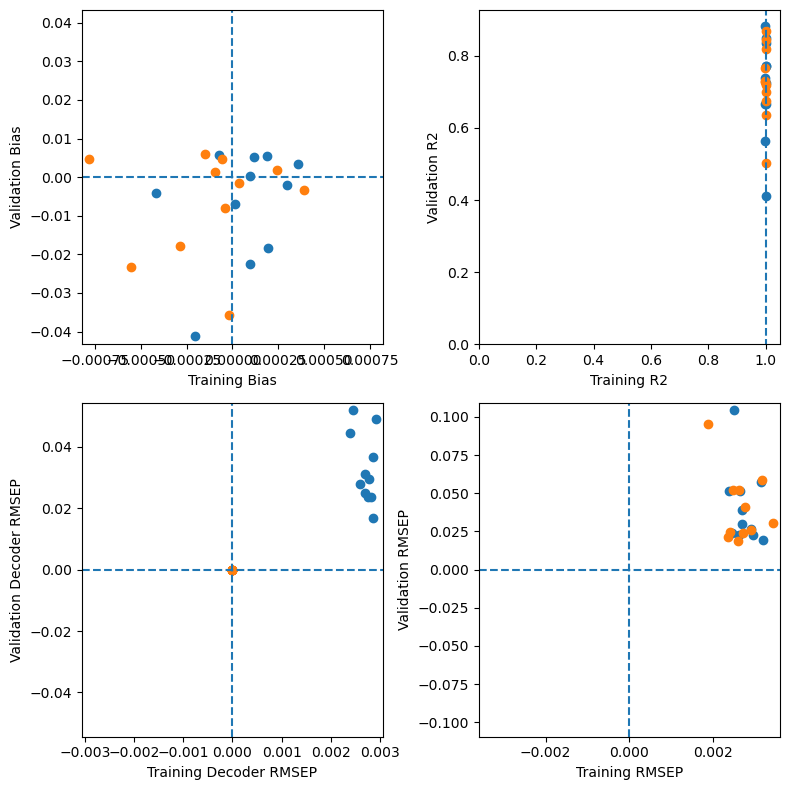

In [349]:
rETBias = []
rETRMSEP = []
rETR2 = []
rEVBias = []
rEVRMSEP = []
rEVR2 = []

rDTRMSEP = []
rDVRMSEP = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'nDTrue' not in name: continue
    if int(name.split('_')[2]) in outlier_regions: 
        print("Skipping", name)
        continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('nDTrue', 'nDFalse')
    cpNm = cpNm.replace('dMFalse', 'dMTrue')

    ETBiasEO = dfETBias[name + ' - Encoder_Training_Bias'].dropna().values[-1]
    ETBiasED = dfETBias[cpNm + ' - Encoder_Training_Bias'].dropna().values[-1]

    ETRMSEPEO = dfETRMSEP[name + ' - Encoder_Training_RMSEP'].dropna().values[-1]
    ETRMSEPED = dfETRMSEP[cpNm + ' - Encoder_Training_RMSEP'].dropna().values[-1]

    ETR2EO = dfETR2[name + ' - Encoder_Training_R2'].dropna().values[-1]
    ETR2ED = dfETR2[cpNm + ' - Encoder_Training_R2'].dropna().values[-1]

    EVBiasEO = dfEVBias[name + ' - Encoder_Validation_Bias'].dropna().values[-1]
    EVBiasED = dfEVBias[cpNm + ' - Encoder_Validation_Bias'].dropna().values[-1]
    
    EVRMSEPEO = dfEVRMSEP[name + ' - Encoder_Validation_RMSEP'].dropna().values[-1]
    EVRMSEPED = dfEVRMSEP[cpNm + ' - Encoder_Validation_RMSEP'].dropna().values[-1]

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]


    DTRMSEPEO = dfDTRMSEP[name + ' - Decoder_Training_RMSEP'].dropna().values[-1]
    DTRMSEPED = dfDTRMSEP[cpNm + ' - Decoder_Training_RMSEP'].dropna().values[-1]

    DVRMSEPEO = dfDVRMSEP[name + ' - Decoder_Validation_RMSEP'].dropna().values[-1]
    DVRMSEPED = dfDVRMSEP[cpNm + ' - Decoder_Validation_RMSEP'].dropna().values[-1]

    rETBias.append([ETBiasED , ETBiasEO])
    rETRMSEP.append([ETRMSEPED , ETRMSEPEO])
    rETR2.append([ETR2ED , ETR2EO])
    rEVBias.append([EVBiasED , EVBiasEO])
    rEVRMSEP.append([EVRMSEPED , EVRMSEPEO])
    rEVR2.append([EVR2ED , EVR2EO])
    rDTRMSEP.append([DTRMSEPED, DTRMSEPEO])
    rDVRMSEP.append([DVRMSEPED, DTRMSEPEO])

print()

fix, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(rETBias,rEVBias,'o')
ax[0,0].set_xlabel('Training Bias')
ax[0,0].set_ylabel('Validation Bias')
ax[0,0].set_xlim([-np.max(np.abs(rETBias))*1.05,np.max(np.abs(rETBias))*1.05])
ax[0,0].set_ylim([-np.max(np.abs(rEVBias))*1.05,np.max(np.abs(rEVBias))*1.05])
ax[0,0].vlines(0,-np.max(np.abs(rEVBias))*1.05,np.max(np.abs(rEVBias))*1.05,linestyles='dashed')
ax[0,0].hlines(0,-np.max(np.abs(rETBias))*1.05,np.max(np.abs(rETBias))*1.05,linestyles='dashed')

ax[0,1].plot(rETR2,rEVR2,'o')
ax[0,1].set_xlabel('Training R2')
ax[0,1].set_ylabel('Validation R2')
ax[0,1].set_xlim([0,np.max(np.abs(rETR2))*1.05])
ax[0,1].set_ylim([0,np.max(np.abs(rEVR2))*1.05])
ax[0,1].vlines(1,-np.max(np.abs(rEVR2))*1.05,np.max(np.abs(rEVR2))*1.05,linestyles='dashed')
ax[0,1].hlines(1,-np.max(np.abs(rETR2))*1.05,np.max(np.abs(rETR2))*1.05,linestyles='dashed')

ax[1,1].plot(rETRMSEP,rEVRMSEP,'o')
ax[1,1].set_xlabel('Training RMSEP')
ax[1,1].set_ylabel('Validation RMSEP')
ax[1,1].set_xlim([-np.max(np.abs(rETRMSEP))*1.05,np.max(np.abs(rETRMSEP))*1.05])
ax[1,1].set_ylim([-np.max(np.abs(rEVRMSEP))*1.05,np.max(np.abs(rEVRMSEP))*1.05])
ax[1,1].vlines(0,-np.max(np.abs(rEVRMSEP))*1.05,np.max(np.abs(rEVRMSEP))*1.05,linestyles='dashed')
ax[1,1].hlines(0,-np.max(np.abs(rETRMSEP))*1.05,np.max(np.abs(rETRMSEP))*1.05,linestyles='dashed')

ax[1,0].plot(rDTRMSEP,rDVRMSEP,'o')
ax[1,0].set_xlabel('Training Decoder RMSEP')
ax[1,0].set_ylabel('Validation Decoder RMSEP')
ax[1,0].set_xlim([-np.max(np.abs(rDTRMSEP))*1.05,np.max(np.abs(rDTRMSEP))*1.05])
ax[1,0].set_ylim([-np.max(np.abs(rDVRMSEP))*1.05,np.max(np.abs(rDVRMSEP))*1.05])
ax[1,0].vlines(0,-np.max(np.abs(rDVRMSEP))*1.05,np.max(np.abs(rDVRMSEP))*1.05,linestyles='dashed')
ax[1,0].hlines(0,-np.max(np.abs(rDTRMSEP))*1.05,np.max(np.abs(rDTRMSEP))*1.05,linestyles='dashed')


plt.tight_layout()

In [350]:
rETBias = []
rETRMSEP = []
rETR2 = []
rEVBias = []
rEVRMSEP = []
rEVR2 = []

rDTRMSEP = []
rDVRMSEP = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'nDTrue' not in name: continue
    if int(name.split('_')[2]) not in outlier_regions: 
        print("Skipping", name)
        continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('nDTrue', 'nDFalse')
    cpNm = cpNm.replace('dMFalse', 'dMTrue')

    ETBiasEO = dfETBias[name + ' - Encoder_Training_Bias'].dropna().values[-1]
    ETBiasED = dfETBias[cpNm + ' - Encoder_Training_Bias'].dropna().values[-1]

    ETRMSEPEO = dfETRMSEP[name + ' - Encoder_Training_RMSEP'].dropna().values[-1]
    ETRMSEPED = dfETRMSEP[cpNm + ' - Encoder_Training_RMSEP'].dropna().values[-1]

    ETR2EO = dfETR2[name + ' - Encoder_Training_R2'].dropna().values[-1]
    ETR2ED = dfETR2[cpNm + ' - Encoder_Training_R2'].dropna().values[-1]

    EVBiasEO = dfEVBias[name + ' - Encoder_Validation_Bias'].dropna().values[-1]
    EVBiasED = dfEVBias[cpNm + ' - Encoder_Validation_Bias'].dropna().values[-1]
    
    EVRMSEPEO = dfEVRMSEP[name + ' - Encoder_Validation_RMSEP'].dropna().values[-1]
    EVRMSEPED = dfEVRMSEP[cpNm + ' - Encoder_Validation_RMSEP'].dropna().values[-1]

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]


    DTRMSEPEO = dfDTRMSEP[name + ' - Decoder_Training_RMSEP'].dropna().values[-1]
    DTRMSEPED = dfDTRMSEP[cpNm + ' - Decoder_Training_RMSEP'].dropna().values[-1]

    DVRMSEPEO = dfDVRMSEP[name + ' - Decoder_Validation_RMSEP'].dropna().values[-1]
    DVRMSEPED = dfDVRMSEP[cpNm + ' - Decoder_Validation_RMSEP'].dropna().values[-1]

    rETBias.append(ETBiasED - ETBiasEO)
    rETRMSEP.append(ETRMSEPED - ETRMSEPEO)
    rETR2.append(ETR2ED - ETR2EO)
    rEVBias.append(EVBiasED - EVBiasEO)
    rEVRMSEP.append(EVRMSEPED - EVRMSEPEO)
    rEVR2.append(EVR2ED - EVR2EO)
    rDTRMSEP.append(DTRMSEPED)
    rDVRMSEP.append(DVRMSEPED)

print()
print("###############################:")
print("BIAS:")  
print("Average difference in encoder-only bias from encoder-decoder bias (Training) =",np.mean(np.array(rETBias))," +/- ",np.std(np.array(rETBias)))
print("Average difference in encoder-only bias from encoder-decoder bias (Validation) =",np.mean(np.array(rEVBias))," +/- ",np.std(np.array(rEVBias)))

print("###############################:")
print("RMSEP:")
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Training) =",np.mean(np.array(rETRMSEP))," +/- ",np.std(np.array(rETRMSEP)))
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Validation) =",np.mean(np.array(rEVRMSEP))," +/- ",np.std(np.array(rEVRMSEP)))

print("###############################:")
print("R2:")
print("Average difference in encoder-only bias from encoder-decoder R2 (Training) =",np.mean(np.array(rETR2))," +/- ",np.std(np.array(rETR2)))
print("Average difference in encoder-only bias from encoder-decoder R2 (Validation) =",np.mean(np.array(rEVR2))," +/- ",np.std(np.array(rEVR2)))

print("###############################:")
print("Decoder RMSEP:")
print("Average encoder-decoder decoder RMSEP (Training) =",np.mean(np.array(rDTRMSEP))," +/- ",np.std(np.array(rDTRMSEP)))
print("Average encoder-decoder decoder RMSEP (Validation) =",np.mean(np.array(rDVRMSEP))," +/- ",np.std(np.array(rDVRMSEP)))

Skipping glasswing_s_10_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_11_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_12_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_13_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_14_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_15_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_1_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_2_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_4_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_7_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_9_2_nDTrue_dRFalse_dMFalse_ffFalse

###############################:
BIAS:
Average difference in encoder-only bias from encoder-decoder bias (Training) = -0.00012082654999999997  +/-  0.0003197747363527318
Average difference in encoder-only bias from encoder-decoder bias (Validation) = -0.000641473166666667  +/-  0.0012164624885470739
###############################:
RMSEP:
Average difference in encoder-only b

Skipping glasswing_s_10_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_11_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_12_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_13_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_14_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_15_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_1_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_2_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_4_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_7_2_nDTrue_dRFalse_dMFalse_ffFalse
Skipping glasswing_s_9_2_nDTrue_dRFalse_dMFalse_ffFalse



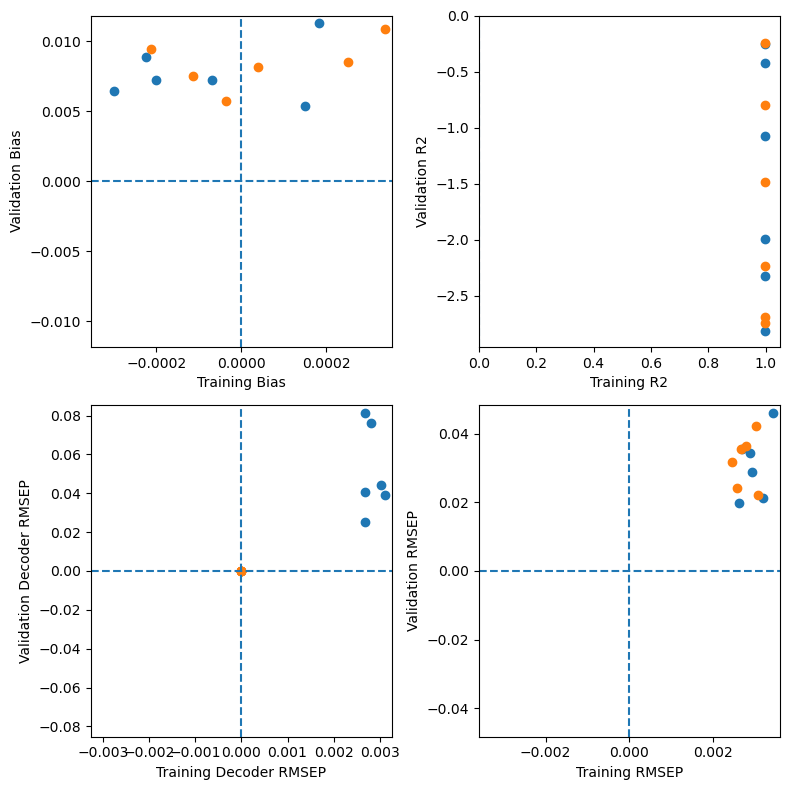

In [353]:
rETBias = []
rETRMSEP = []
rETR2 = []
rEVBias = []
rEVRMSEP = []
rEVR2 = []

rDTRMSEP = []
rDVRMSEP = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'nDTrue' not in name: continue
    if int(name.split('_')[2]) not in outlier_regions: 
        print("Skipping", name)
        continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('nDTrue', 'nDFalse')
    cpNm = cpNm.replace('dMFalse', 'dMTrue')

    ETBiasEO = dfETBias[name + ' - Encoder_Training_Bias'].dropna().values[-1]
    ETBiasED = dfETBias[cpNm + ' - Encoder_Training_Bias'].dropna().values[-1]

    ETRMSEPEO = dfETRMSEP[name + ' - Encoder_Training_RMSEP'].dropna().values[-1]
    ETRMSEPED = dfETRMSEP[cpNm + ' - Encoder_Training_RMSEP'].dropna().values[-1]

    ETR2EO = dfETR2[name + ' - Encoder_Training_R2'].dropna().values[-1]
    ETR2ED = dfETR2[cpNm + ' - Encoder_Training_R2'].dropna().values[-1]

    EVBiasEO = dfEVBias[name + ' - Encoder_Validation_Bias'].dropna().values[-1]
    EVBiasED = dfEVBias[cpNm + ' - Encoder_Validation_Bias'].dropna().values[-1]
    
    EVRMSEPEO = dfEVRMSEP[name + ' - Encoder_Validation_RMSEP'].dropna().values[-1]
    EVRMSEPED = dfEVRMSEP[cpNm + ' - Encoder_Validation_RMSEP'].dropna().values[-1]

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]


    DTRMSEPEO = dfDTRMSEP[name + ' - Decoder_Training_RMSEP'].dropna().values[-1]
    DTRMSEPED = dfDTRMSEP[cpNm + ' - Decoder_Training_RMSEP'].dropna().values[-1]

    DVRMSEPEO = dfDVRMSEP[name + ' - Decoder_Validation_RMSEP'].dropna().values[-1]
    DVRMSEPED = dfDVRMSEP[cpNm + ' - Decoder_Validation_RMSEP'].dropna().values[-1]

    rETBias.append([ETBiasED , ETBiasEO])
    rETRMSEP.append([ETRMSEPED , ETRMSEPEO])
    rETR2.append([ETR2ED , ETR2EO])
    rEVBias.append([EVBiasED , EVBiasEO])
    rEVRMSEP.append([EVRMSEPED , EVRMSEPEO])
    rEVR2.append([EVR2ED , EVR2EO])
    rDTRMSEP.append([DTRMSEPED, DTRMSEPEO])
    rDVRMSEP.append([DVRMSEPED, DTRMSEPEO])

print()

fix, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(rETBias,rEVBias,'o')
ax[0,0].set_xlabel('Training Bias')
ax[0,0].set_ylabel('Validation Bias')
ax[0,0].set_xlim([-np.max(np.abs(rETBias))*1.05,np.max(np.abs(rETBias))*1.05])
ax[0,0].set_ylim([-np.max(np.abs(rEVBias))*1.05,np.max(np.abs(rEVBias))*1.05])
ax[0,0].vlines(0,-np.max(np.abs(rEVBias))*1.05,np.max(np.abs(rEVBias))*1.05,linestyles='dashed')
ax[0,0].hlines(0,-np.max(np.abs(rETBias))*1.05,np.max(np.abs(rETBias))*1.05,linestyles='dashed')

ax[0,1].plot(rETR2,rEVR2,'o')
ax[0,1].set_xlabel('Training R2')
ax[0,1].set_ylabel('Validation R2')
ax[0,1].set_xlim([0,1.05])
ax[0,1].set_ylim([-np.max(np.abs(rEVR2))*1.05,0])
ax[0,1].vlines(0,-np.max(np.abs(rEVR2))*1.05,0,linestyles='dashed')
ax[0,1].hlines(0,-np.max(np.abs(rETR2))*1.05,0,linestyles='dashed')

ax[1,1].plot(rETRMSEP,rEVRMSEP,'o')
ax[1,1].set_xlabel('Training RMSEP')
ax[1,1].set_ylabel('Validation RMSEP')
ax[1,1].set_xlim([-np.max(np.abs(rETRMSEP))*1.05,np.max(np.abs(rETRMSEP))*1.05])
ax[1,1].set_ylim([-np.max(np.abs(rEVRMSEP))*1.05,np.max(np.abs(rEVRMSEP))*1.05])
ax[1,1].vlines(0,-np.max(np.abs(rEVRMSEP))*1.05,np.max(np.abs(rEVRMSEP))*1.05,linestyles='dashed')
ax[1,1].hlines(0,-np.max(np.abs(rETRMSEP))*1.05,np.max(np.abs(rETRMSEP))*1.05,linestyles='dashed')

ax[1,0].plot(rDTRMSEP,rDVRMSEP,'o')
ax[1,0].set_xlabel('Training Decoder RMSEP')
ax[1,0].set_ylabel('Validation Decoder RMSEP')
ax[1,0].set_xlim([-np.max(np.abs(rDTRMSEP))*1.05,np.max(np.abs(rDTRMSEP))*1.05])
ax[1,0].set_ylim([-np.max(np.abs(rDVRMSEP))*1.05,np.max(np.abs(rDVRMSEP))*1.05])
ax[1,0].vlines(0,-np.max(np.abs(rDVRMSEP))*1.05,np.max(np.abs(rDVRMSEP))*1.05,linestyles='dashed')
ax[1,0].hlines(0,-np.max(np.abs(rDTRMSEP))*1.05,np.max(np.abs(rDTRMSEP))*1.05,linestyles='dashed')


plt.tight_layout()

## Experiment 2: Comparing physical model to E2E encoder-decoder

In [360]:
rETBias = []
rETRMSEP = []
rETR2 = []
rEVBias = []
rEVRMSEP = []
rEVR2 = []

rDTRMSEP = []
rDVRMSEP = []

for name in uniqueNames:
    # Get only E2E encoder-only trainings
    if 'dMTrue' not in name: continue
    # if int(name.split('_')[2]) not in outlier_regions: 
    #     print("Skipping", name)
    #     continue

    # Get corresponding E2E encoder-decoder training
    cpNm = name.replace('dMTrue', 'dMFalse')

    ETBiasEO = dfETBias[name + ' - Encoder_Training_Bias'].dropna().values[-1]
    ETBiasED = dfETBias[cpNm + ' - Encoder_Training_Bias'].dropna().values[-1]

    ETRMSEPEO = dfETRMSEP[name + ' - Encoder_Training_RMSEP'].dropna().values[-1]
    ETRMSEPED = dfETRMSEP[cpNm + ' - Encoder_Training_RMSEP'].dropna().values[-1]

    ETR2EO = dfETR2[name + ' - Encoder_Training_R2'].dropna().values[-1]
    ETR2ED = dfETR2[cpNm + ' - Encoder_Training_R2'].dropna().values[-1]

    EVBiasEO = dfEVBias[name + ' - Encoder_Validation_Bias'].dropna().values[-1]
    EVBiasED = dfEVBias[cpNm + ' - Encoder_Validation_Bias'].dropna().values[-1]
    
    EVRMSEPEO = dfEVRMSEP[name + ' - Encoder_Validation_RMSEP'].dropna().values[-1]
    EVRMSEPED = dfEVRMSEP[cpNm + ' - Encoder_Validation_RMSEP'].dropna().values[-1]

    EVR2EO = dfEVR2[name + ' - Encoder_Validation_R2'].dropna().values[-1]
    EVR2ED = dfEVR2[cpNm + ' - Encoder_Validation_R2'].dropna().values[-1]


    DTRMSEPEO = dfDTRMSEP[name + ' - Decoder_Training_RMSEP'].dropna().values[-1]
    DTRMSEPED = dfDTRMSEP[cpNm + ' - Decoder_Training_RMSEP'].dropna().values[-1]

    DVRMSEPEO = dfDVRMSEP[name + ' - Decoder_Validation_RMSEP'].dropna().values[-1]
    DVRMSEPED = dfDVRMSEP[cpNm + ' - Decoder_Validation_RMSEP'].dropna().values[-1]

    rETBias.append(ETBiasED - ETBiasEO)
    rETRMSEP.append(ETRMSEPED - ETRMSEPEO)
    rETR2.append(ETR2ED - ETR2EO)
    rEVBias.append(EVBiasED - EVBiasEO)
    rEVRMSEP.append(EVRMSEPED - EVRMSEPEO)
    rEVR2.append(EVR2ED - EVR2EO)
    rDTRMSEP.append(DTRMSEPED - DTRMSEPEO)
    rDVRMSEP.append(DVRMSEPED - DVRMSEPEO)

print()
print("###############################:")
print("BIAS:")  
print("Average difference in encoder-only bias from encoder-decoder bias (Training) =",np.mean(np.array(rETBias))," +/- ",np.std(np.array(rETBias)))
print("Average difference in encoder-only bias from encoder-decoder bias (Validation) =",np.mean(np.array(rEVBias))," +/- ",np.std(np.array(rEVBias)))

print("###############################:")
print("RMSEP:")
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Training) =",np.mean(np.array(rETRMSEP))," +/- ",np.std(np.array(rETRMSEP)))
print("Average difference in encoder-only bias from encoder-decoder RMSEP (Validation) =",np.mean(np.array(rEVRMSEP))," +/- ",np.std(np.array(rEVRMSEP)))

print("###############################:")
print("R2:")
print("Average difference in encoder-only bias from encoder-decoder R2 (Training) =",np.mean(np.array(rETR2))," +/- ",np.std(np.array(rETR2)))
print("Average difference in encoder-only bias from encoder-decoder R2 (Validation) =",np.mean(np.array(rEVR2))," +/- ",np.std(np.array(rEVR2)))

print("###############################:")
print("Decoder RMSEP:")
print("Average encoder-decoder decoder RMSEP (Training) =",np.mean(np.array(rDTRMSEP))," +/- ",np.std(np.array(rDTRMSEP)))
print("Average encoder-decoder decoder RMSEP (Validation) =",np.mean(np.array(rDVRMSEP))," +/- ",np.std(np.array(rDVRMSEP)))

Skipping glasswing_s_16_2_nDFalse_dRFalse_dMTrue_ffFalse
Skipping glasswing_s_18_2_nDFalse_dRFalse_dMTrue_ffFalse
Skipping glasswing_s_3_2_nDFalse_dRFalse_dMTrue_ffFalse
Skipping glasswing_s_5_2_nDFalse_dRFalse_dMTrue_ffFalse
Skipping glasswing_s_6_2_nDFalse_dRFalse_dMTrue_ffFalse
Skipping glasswing_s_8_2_nDFalse_dRFalse_dMTrue_ffFalse

###############################:
BIAS:
Average difference in encoder-only bias from encoder-decoder bias (Training) = 0.00028754731818181816  +/-  0.00036726410587426743
Average difference in encoder-only bias from encoder-decoder bias (Validation) = 0.0010026349090909087  +/-  0.0010641585449387998
###############################:
RMSEP:
Average difference in encoder-only bias from encoder-decoder RMSEP (Training) = 0.00010798490909090905  +/-  0.000362162230154201
Average difference in encoder-only bias from encoder-decoder RMSEP (Validation) = 7.32465454545442e-05  +/-  0.0024999491184519006
###############################:
R2:
Average difference in 

## Plotting SOC spectral data $f_{SOC}(\lambda)$

Here is some sample code to generate nice plots of posterior distributions of $f_{SOC}(\lambda)$.

Immediately below are a list of wavelengths associated to spectral absorption by organic functional groups, as well as some helper variables.

In [39]:
organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]
organicTroughs = list(set(organicTroughs))

waterTroughs = [970, 1450, 1200, 1950]
calciteTroughs = [2340]
MSpectra = 2151
NTest = 100
XF = np.array([x for x in range(365,2501)]);

Here we generate 100 fake seed spectra at random:

In [120]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

tFsoc = np.ones([NTest,MSpectra])*0.8
seedFsoc = tFsoc - 0.5*(np.random.randn(NTest,1)*0.6 + 0.3) *np.sum(fakeTrough((np.ones([1,MSpectra])*XF).T,np.array(organicTroughs),1000*gaus(1.0,0.35,len(organicTroughs))).T,axis=0)

Now we plot the reflectance quantiles:

glasswing_s_\d*_\w*False_\w*False_\w*False_\w*False

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a pandas dataframe
df = pd.read_csv("results/SOC-spectra-10kepochs.csv")

# Group the dataframe by 'name' and sort 'SOC Reflectance' in ascending order by 'Wavelength' for each group
sorted_arrays = df.groupby('name').apply(lambda x: x.sort_values('Wavelength')['SOC Reflectance'].values)

# Collect the sorted 'SOC Reflectance' arrays into a separate array
result = np.array(sorted_arrays.tolist())

print(result.shape)



(17, 2136)


In [69]:
import copy

# Load the CSV file into a pandas dataframe
dfrr = pd.read_csv("results/SOC-rr-10kepochs.csv")

result_columns = []
result_array = copy.deepcopy(sorted_arrays)

for name in df['name'].unique():
    column = dfrr.loc[dfrr['Step'] == 20404, name + ' - rrSOC'].values
    result_columns.append(column)
    result_array[name] = column

result_columns = np.array(result_columns)

print(result_columns.shape)



(17, 1)


In [172]:
import scipy
from sklearn.metrics import r2_score

correlation_coefficients = []
for i in range(2135) :
    refs = []
    rrs = []
    for nm in df['name'].unique():
        refs.append(sorted_arrays[nm][i+1] - sorted_arrays[nm][i])
        rrs.append(sorted_arrays[nm][i])

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(rrs, refs)
    correlation_coefficient = r_value
    correlation_coefficients.append(correlation_coefficient)

correlation_coefficients = np.array(correlation_coefficients)


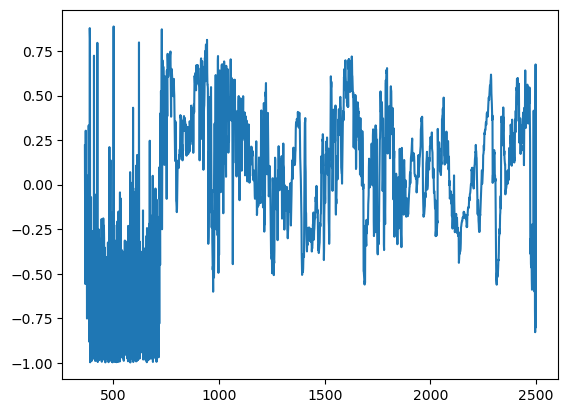

In [174]:
plt.plot(XF[:-1],correlation_coefficients)

In [49]:
XF = np.array([x for x in range(365,2501)]);

In [133]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv("results/SOC-spectrum-fullfit.csv")

# Group the dataframe by 'name' and sort 'SOC Reflectance' in ascending order by 'Wavelength' for each group
sorted_arrays_full = df.groupby('name').apply(lambda x: x.sort_values('Wavelength')['SOC Reflectance'].values)

print(sorted_arrays_full)

# Collect the sorted 'SOC Reflectance' arrays into a separate array
result_full = np.array(sorted_arrays_full.tolist())

print(result_full.shape)



name
glasswing_s_-1_-1_nDFalse_dRFalse_dMFalse_ffTrue    [0.073849067, 0.048634734, 0.0293209869414567,...
dtype: object
(1, 2136)


/var/folders/84/rsxv09b17_n57vhqltwy0p900000gn/T/ipykernel_27977/2490485809.py:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='orange', alpha=0.2, label="Visible spectrum")


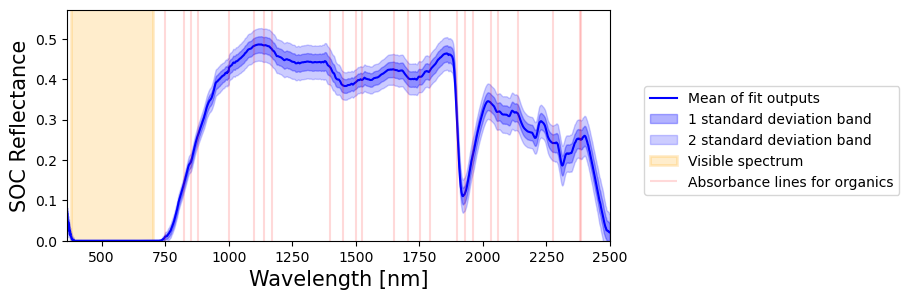

In [201]:
#enable latex rendering
plt.rcParams['text.usetex'] = False

fig = plt.figure(figsize=(7, 3))



# Plot quantiles
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=0),np.quantile(socspecs,0.005,axis=0),color='blue',alpha=0.1,label=r'99\% CL band of fit outputs')
plt.plot(XF,np.mean(result,axis=0), color='blue', label=r'Mean of fit outputs');
plt.fill_between(XF,np.mean(result,axis=0) + np.std(result,axis=0), np.mean(result,axis=0) - np.std(result,axis=0),color='blue',alpha=0.3,label=r'1 standard deviation band')
plt.fill_between(XF,np.mean(result,axis=0) + 2* np.std(result,axis=0),np.mean(result,axis=0) - 2 *np.std(result,axis=0),color='blue',alpha=0.2,label=r'2 standard deviation band')

# Plot means and mins
# plt.plot(XF,np.max(result,axis=0), color='black',alpha=0.4);
#plt.plot(XF,result_full[0,:], color='black', label=r'Full fit');
# plt.plot(XF,np.min(result,axis=0), color='black',alpha=0.4,  label=r'Range');

# Style plot
plt.xlim([365.0,2500.0])
plt.ylim([0.0,np.max(result)*1.1])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'SOC Reflectance',fontsize=15)
#plt.title(r'Example SOC spectrum plot: distributed priors',fontsize=20)

# Add the rectangle
rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='orange', alpha=0.2, label="Visible spectrum")
plt.gca().add_patch(rectangle)


# Add absorbance lines for organics
plt.vlines(organicTroughs,ymin=0.0,ymax=1.0, color='red', alpha=0.15, label="Absorbance lines for organics")
#plt.vlines(waterTroughs,ymin=0.0,ymax=1.0, color='yellow', alpha=1, label="Absorbance lines for hygroscopic water")
# plt.vlines(calciteTroughs,ymin=0.0,ymax=1.0, color='green', alpha=1, label="Absorbance lines for calcite")

# Add legend
plt.legend(loc='best', bbox_to_anchor=(1.05,0.7));

/var/folders/84/rsxv09b17_n57vhqltwy0p900000gn/T/ipykernel_27977/2128178009.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(XF,np.log((1 - result)**2/2./result).T, color='black',alpha=0.4);
/var/folders/84/rsxv09b17_n57vhqltwy0p900000gn/T/ipykernel_27977/2128178009.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='yellow', alpha=0.2, label="Visible spectrum")


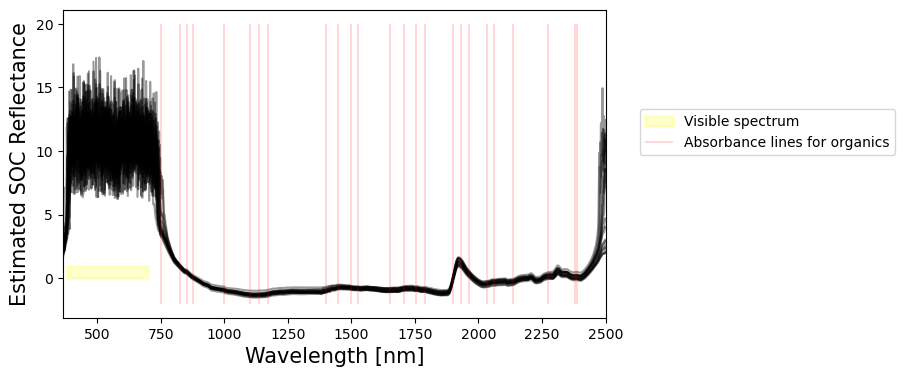

In [159]:
fig = plt.figure(figsize=(7, 4))

# Plot means and mins
plt.plot(XF,np.log((1 - result)**2/2./result).T, color='black',alpha=0.4);

# Style plot
plt.xlim([365.0,2500.0])
#plt.ylim([0.0,np.max(result)*1.1])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Estimated SOC Reflectance',fontsize=15)
#plt.title(r'Example SOC spectrum plot: distributed priors',fontsize=20)

# Add the rectangle
rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='yellow', alpha=0.2, label="Visible spectrum")
plt.gca().add_patch(rectangle)


# Add absorbance lines for organics
plt.vlines(organicTroughs,ymin=-2.0,ymax=20, color='red', alpha=0.15, label="Absorbance lines for organics")
#plt.vlines(waterTroughs,ymin=0.0,ymax=1.0, color='yellow', alpha=1, label="Absorbance lines for hygroscopic water")
# plt.vlines(calciteTroughs,ymin=0.0,ymax=1.0, color='green', alpha=1, label="Absorbance lines for calcite")

# Add legend
plt.legend(loc='best', bbox_to_anchor=(1.05,0.7));

In [142]:
print(np.diff(result,axis=1).shape)

(17, 2135)


/var/folders/84/rsxv09b17_n57vhqltwy0p900000gn/T/ipykernel_27977/194684795.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='yellow', alpha=0.2, label="Visible spectrum")


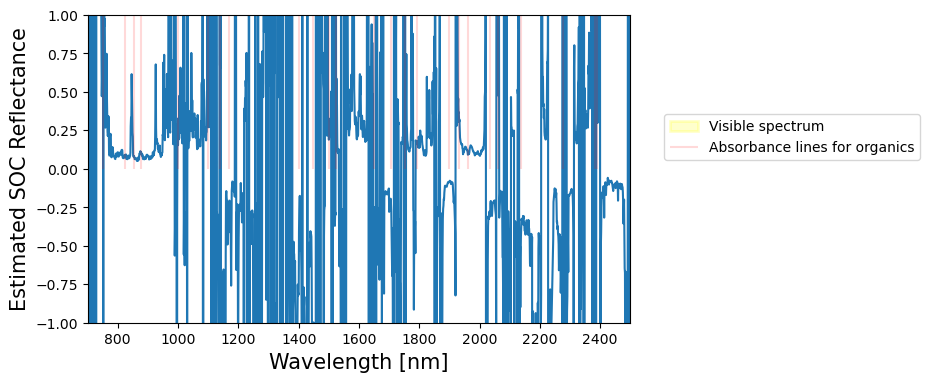

In [181]:
fig = plt.figure(figsize=(7, 4))

resultdiff = np.diff(result,axis=1)

plt.plot(XF[:-1],(np.quantile(resultdiff,0.84,axis=0) - np.quantile(resultdiff,0.16,axis=0))/np.mean(resultdiff,axis=0))

# Plot quantiles
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=0),np.quantile(socspecs,0.005,axis=0),color='blue',alpha=0.1,label=r'99\% CL band of fit outputs')
# plt.fill_between(XF[-1],np.quantile(resultdiff,0.975,axis=0),np.quantile(resultdiff,0.025,axis=0),color='blue',alpha=0.2,label=r'Inner 95% quantile of fit outputs')
# plt.fill_between(XF[-1],np.quantile(resultdiff,0.84,axis=0),np.quantile(resultdiff,0.16,axis=0),color='blue',alpha=0.3,label=r'Inner 68% quantile of fit outputs')

# Plot means and mins
# plt.plot(XF[:-1],np.max(resultdiff,axis=0), color='black',alpha=0.4);
# plt.plot(XF[:-1],np.median(resultdiff,axis=0), color='blue', label=r'Median');
# #plt.plot(XF,result_full[0,:], color='black', label=r'Full fit');
# plt.plot(XF[:-1],np.min(resultdiff,axis=0), color='black',alpha=0.4,  label=r'Range');

# Style plot
plt.xlim([701.0,2500.0])
plt.ylim([-1.0,1.0])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Estimated SOC Reflectance',fontsize=15)
#plt.title(r'Example SOC spectrum plot: distributed priors',fontsize=20)

# Add the rectangle
rectangle = plt.Rectangle((380, 0), 700-380, 1, edgecolor='black', linewidth=2, color='yellow', alpha=0.2, label="Visible spectrum")
plt.gca().add_patch(rectangle)


# Add absorbance lines for organics
plt.vlines(organicTroughs,ymin=0.0,ymax=1.0, color='red', alpha=0.15, label="Absorbance lines for organics")
#plt.vlines(waterTroughs,ymin=0.0,ymax=1.0, color='yellow', alpha=1, label="Absorbance lines for hygroscopic water")
# plt.vlines(calciteTroughs,ymin=0.0,ymax=1.0, color='green', alpha=1, label="Absorbance lines for calcite")

# Add legend
plt.legend(loc='best', bbox_to_anchor=(1.05,0.7));

## Plotting geographic data 

The pandas dataframe has a column called 'y' and 'x' which are latitudes and longitudes, respectively.

Here we make an example histogram plot of the density of the samples overlaid on a map of the United States.

In [6]:
from scipy.stats import gaussian_kde

regions = [i for i in range(1, 17)] + [18]

lats = {}
longs = {}
zs = {}

for i in regions: 
    print (i)
    lat = joined[joined["region"] == i]['lat']
    long = joined[joined["region"] == i]['long']
    
    xy = np.vstack([lat,long])
    z = gaussian_kde(xy)(xy)

    lats[i] = lat
    longs[i] = long
    zs[i] = z


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18


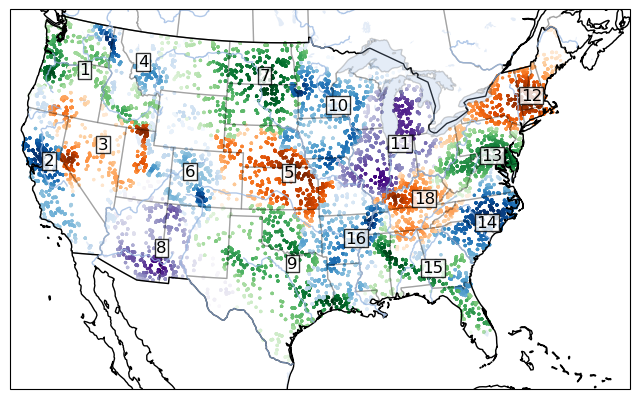

In [120]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
# Create a figure
fig = plt.figure(figsize=(8, 15))

# Create a GeoAxes in the figure with Albers Equal Area projection
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5))

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.25)
ax.add_feature(cfeature.RIVERS, alpha=0.75)

# Overlay scatterplot of sample density
cmaps = ["Oranges", "Greens", "Blues", "Oranges", "Blues", "Oranges", "Blues", "Greens", "Purples", "Greens", "Blues", "Purples", "Oranges", "Greens", "Blues", "Greens", "Blues", "Greys", "Oranges"] + ["Greys"] * 18
for i in regions:
    ax.scatter(np.array(longs[i]), lats[i], c=zs[i], s=2, cmap=cmaps[i], transform=ccrs.PlateCarree())
    
    # add text label to the map for each region number
    # with bounding box white and black border
    ax.text(np.median(longs[i]), np.median(lats[i]), str(i), transform=ccrs.PlateCarree(), color='black', fontsize=12, bbox=dict(facecolor='white', pad=1.0, alpha=0.8))


# # Tessellate the map into polygons
# points = np.column_stack((np.concatenate(list(longs.values())), np.concatenate(list(lats.values()))))
# vor = Voronoi(points)

# # Assign each polygon the index 'i' in regions associated with the point geographically closest to that polygon
# for i, region in enumerate(regions):
#     region_points = np.column_stack((longs[region], lats[region]))
#     #print(region_points)
#     region_indices = np.argwhere(np.all(points == region_points, axis=0)).flatten()
#     region_polygon = voronoi_plot_2d(vor, ax=ax, regions=region_indices, show_vertices=False, line_colors='black', line_width=2, line_alpha=1,transform=ccrs.PlateCarree())

# voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1)
# for r in range(len(vor.point_region)):
#     region = vor.regions[vor.point_region[r]]
#     if not -1 in region:
#         polygon = [vor.vertices[i] for i in region]
#         plt.fill(*zip(*polygon), color='r')
# plt.show()

# Restrict to the continental United States
ax.set_extent([-120, -70, 22, 49])

# Show the plot
plt.show()


In [25]:
np.max(z)

0.005131822918721993

In [3]:
print(len(joined))

23550
